# Compression examples
In this notebook we compare constraints on cosmological parameters obtained with different types of compressions (shapefit, full).
Notebooks fs_shapefit_examples.ipynb & fs_full_examples.ipnyb must be run first to produce the samples needed in this notebook.

## BAO compression
As a warm-up, what constraints on $\Omega_m$ do we obtain from an isotropic BAO fit?

In [1]:
from desilike.samples import Chain
from desilike import setup_logging

setup_logging()
chain = Chain.load('_tests/chain_bao_0.npy').remove_burnin(0.3)
z = 1.

[000000.01] [0/1] 12-05 13:51  Chain                     INFO     Loading _tests/chain_bao_0.npy.


In [2]:
import numpy as np

from desilike.theories.primordial_cosmology import Cosmoprimo
from desilike.observables.galaxy_clustering import BAOCompression
from desilike.likelihoods import GaussianLikelihood

cosmo = Cosmoprimo(fiducial='DESI')
cosmo.params = {'Omega_m': {'prior': {'limits': [0.05, 0.9]},
                            'ref': {'limits': [0.30, 0.33]},
                            'latex': '\Omega_{m}'}}
quantities = ['qiso']
observable = BAOCompression(data=chain, covariance=chain, cosmo=cosmo, z=z, quantities=quantities)
likelihood = GaussianLikelihood(observables=[observable])

# Note that you can directly pass arrays as data and covariance, in addition to "quantities"
quantities = ['qiso']
data = chain.choice(params=quantities, return_type='nparray')
covariance = chain.cov(params=quantities, return_type='nparray')
observable = BAOCompression(data=data, covariance=covariance, quantities=quantities, z=z)
likelihood2 = GaussianLikelihood(observables=[observable])
assert np.allclose(likelihood2(Omega_m=0.29), likelihood(Omega_m=0.29))

[000000.57] [0/1] 12-05 13:51  BAOCompression            INFO     Found BAO quantities ['qiso'].
[000000.72] [0/1] 12-05 13:51  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.72] [0/1] 12-05 13:51  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.72] [0/1] 12-05 13:51  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.72] [0/1] 12-05 13:51  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.72] [0/1] 12-05 13:51  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[000000.80] [0/1] 12-05 13:51  BAOCompression            INFO     Found BAO quantit

In [3]:
# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=4))
emulator.set_samples(ref_scale=1.)
emulator.fit()
emulator.check()
likelihood.update(observables=[emulator.to_calculator()])

[000001.10] [0/1] 12-05 13:51  Emulator                  INFO     Varied parameters: ['Omega_m'].
[000001.10] [0/1] 12-05 13:51  Emulator                  INFO     Found varying ['flatmodel'] and fixed ['flatdata', 'covariance', 'bao_quantities'] outputs.
[000001.34] [0/1] 12-05 13:51  Emulator                  INFO     Diagnostics:
[000001.40] [0/1] 12-05 13:51  Emulator                  INFO     - mse of flatmodel is 7.96e-10 (square root = 2.82e-05).


In [4]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000001.41] [0/1] 12-05 13:51  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[000003.01] [0/1] 12-05 13:51  EmceeSampler              INFO     Diagnostics:
[000003.01] [0/1] 12-05 13:51  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.125; not < 0.04.
[000003.01] [0/1] 12-05 13:51  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.125.
[000003.02] [0/1] 12-05 13:51  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.709.
[000003.02] [0/1] 12-05 13:51  EmceeSampler              INFO     - max Geweke is 0.549.
[000003.02] [0/1] 12-05 13:51  EmceeSampler              INFO     - Geweke p-value is nan.
[000003.03] [0/1] 12-05 13:51  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 16.2.
[000004.58] [0/1] 12-05 13:51  EmceeSampler              INFO     Diagnostics:
[000004.58] [0/1] 12-05 13:51  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is

[000007.74] [0/1] 12-05 13:51  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


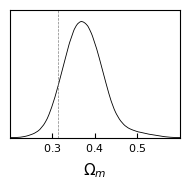

In [5]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.bao.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})

## Shapefit compression
Now turn to shapefit compression.

In [6]:
from desilike.observables.galaxy_clustering import ShapeFitCompression

chain = Chain.load('_tests/chain_fs_shapefit_0.npy').remove_burnin(0.3)

quantities = ['qpar', 'qper', 'f', 'dm']
observable = ShapeFitCompression(data=chain, covariance=chain, z=z, quantities=quantities)
likelihood = GaussianLikelihood(observables=[observable])

# A bit of emulation, to speed up inference
from desilike.emulators import Emulator, TaylorEmulatorEngine
emulator = Emulator(observable, engine=TaylorEmulatorEngine(order=3))
emulator.set_samples(ref_scale=1.)
emulator.fit()
emulator.check()
likelihood.update(observables=[emulator.to_calculator()])

[000008.05] [0/1] 12-05 13:51  Chain                     INFO     Loading _tests/chain_fs_shapefit_0.npy.
[000008.06] [0/1] 12-05 13:51  ShapeFitCompression       INFO     Found BAO quantities ['qpar', 'qper'].
[000008.06] [0/1] 12-05 13:51  ShapeFitCompression       INFO     Found FS quantities ['df', 'dm'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000010.90] [0/1] 12-05 13:51  Emulator                  INFO     Varied parameters: ['Omega_m', 'A_s', 'h'].
[000010.90] [0/1] 12-05 13:51  Emulator                  INFO     Found varying ['flatmodel'] and fixed ['flatdata', 'covariance', 'bao_quantities', 'fs_quantities'] outputs.
[000135.95] [0/1] 12-05 13:53  Emulator                  INFO     Diagnostics:
[000136.06] [0/1] 12-05 13:53  Emulator                  INFO     - mse of flatmodel is 1.81e-06 (square root = 0.00135).


In [12]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000403.28] [0/1] 12-05 13:58  ZeusSampler               INFO     Varied parameters: ['Omega_m', 'A_s', 'h'].
[000403.30] [0/1] 12-05 13:58  root                      INFO     Initialising ensemble of 8 walkers...
[000423.07] [0/1] 12-05 13:58  ZeusSampler               INFO     Diagnostics:
[000423.08] [0/1] 12-05 13:58  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0536; not < 0.04.
[000423.08] [0/1] 12-05 13:58  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0124.
[000423.09] [0/1] 12-05 13:58  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.177.
[000423.10] [0/1] 12-05 13:58  ZeusSampler               INFO     - max Geweke is 0.522.
[000423.10] [0/1] 12-05 13:58  ZeusSampler               INFO     - Geweke p-value is 0.19.
[000423.10] [0/1] 12-05 13:58  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 34.7.
[000423.12] [0/1] 12-05 13:58  root                      

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000443.97] [0/1] 12-05 13:58  ZeusSampler               INFO     Diagnostics:
[000443.97] [0/1] 12-05 13:58  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.216; not < 0.04.
[000443.98] [0/1] 12-05 13:58  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0231.
[000443.99] [0/1] 12-05 13:58  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0468.
[000444.00] [0/1] 12-05 13:58  ZeusSampler               INFO     - max Geweke is 0.579.
[000444.00] [0/1] 12-05 13:58  ZeusSampler               INFO     - Geweke p-value is 0.827.
[000444.00] [0/1] 12-05 13:58  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 53.9.
[000444.00] [0/1] 12-05 13:58  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.247.
[000444.02] [0/1] 12-05 13:58  root                      INFO     Initialising ensemble of 8 walkers...
[000464.19] [0/1] 12-05 13:5

[003338.16] [0/1] 12-05 14:47  Chain                     INFO     Loading _tests/chain_fs_full_0.npy.
Removed no burn in
Removed no burn in


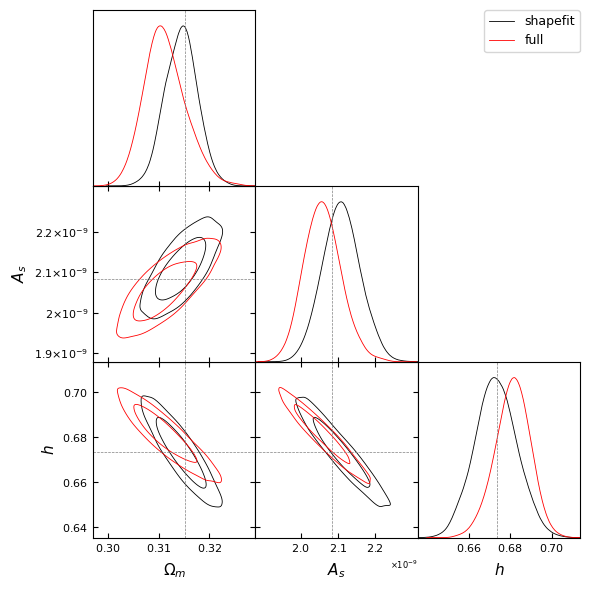

In [15]:
from desilike.samples import plotting
chain_shapefit = sampler.chains[0].remove_burnin(0.5)
chain_full = Chain.load('_tests/chain_fs_full_0.npy').remove_burnin(0.5)
plotting.plot_triangle([chain, chain_full], fill=True, labels=['shapefit', 'full'], markers={'Omega_m': fiducial.Omega0_m, 'h': fiducial.h, 'A_s': fiducial.A_s, 'n_s': fiducial.n_s})